In [3]:
import os
import csv
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics as st
import seaborn as sns
from scipy import stats
from IPython.display import HTML, display
import tabulate
%matplotlib inline  
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['axes.labelweight'] = 'bold'
sns.set_palette("bright", 10)

In [4]:
def walk_shallow(target_dir):
    target_dir = target_dir.rstrip(os.path.sep)
    num_sep = target_dir.count(os.path.sep)
    for root, dirs, files in os.walk(target_dir):
        yield root, dirs, files
        num_sep_curr = root.count(os.path.sep)
        if num_sep + 1 <= num_sep_curr:
            del dirs[:]

In [5]:
def format_time(millis):
    seconds = (millis / 1000) % 60
    seconds = int(seconds)
    minutes = (millis / (1000 * 60)) % 60
    minutes = int(minutes)

    return '{:02d}:{:02d}'.format(minutes, seconds)

In [6]:
config_tt = np.empty(shape=(10, 4))
config_tt_rev = np.empty(shape=(4, 10))
config_gens = np.empty(shape=(4, 10, 300), dtype=object)
config_fvs = np.empty(shape=(4, 10))
config_modes = ['c0', 'c15', 'c2', 'c4']

for i in range(4):
    for j in range(10):
        for k in range(300):
            config_gens[i, j, k] = []

# Obtain total execution and generation times for modes
for d in walk_shallow("../data"):
    if len(d[1]) < 6:
        for i, mode in enumerate(config_modes):
            gen_path = os.path.join(d[0], mode, 'cpga_generation_reporter.csv')
            # get inspected directory name, case it to integer
            dir_index = int(d[0].split('/')[-1]) - 1
            with open(gen_path, 'r') as csvFile:
                reader = csv.reader(csvFile)
                total_rows = []
                for row in reader:
                    if row[3] == 'execute_generation':
                        config_gens[i, dir_index, int(row[4])].append(int(row[2]))
                    elif row[3] == 'total':
                        total_rows.append(int(row[2]))
                        
                config_tt[dir_index, i] = st.mean(total_rows)
                config_tt_rev[i, dir_index] = config_tt[dir_index, i]
            csvFile.close()
            
            ind_path = os.path.join(d[0], mode, 'cpga_individual_reporter.csv')
            with open(ind_path, 'r') as csvFile:
                reader = csv.reader(csvFile)
                next(reader, None)
                max_fv = 0
                for row in reader:
                    if float(row[4]) > max_fv:
                        max_fv = float(row[4])
                        
                config_fvs[i, dir_index] = max_fv
            csvFile.close()            

In [7]:
# mean, sd, median table for c0, c2, c4 and c8
summaries = [[st.mean(x), st.stdev(x), st.median(x)] for x in config_tt_rev]
summaries_formatted = [map(format_time, x) for x in summaries]
display(HTML(tabulate.tabulate(summaries_formatted, tablefmt='html')))

20:41,02:35,20:44
11:39,04:48,10:29
09:13,02:12,09:54
09:04,02:33,09:43


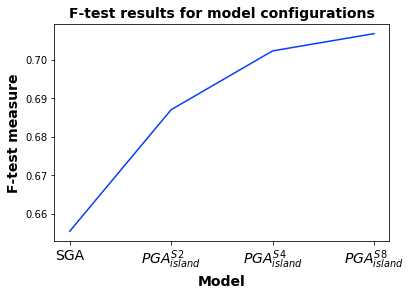

[0.655462185, 0.687022901, 0.702290076, 0.706766917]


In [10]:
# results of the f-test in model configurations
fvs_maxes = [max(x) for x in config_fvs]
plt.plot(fvs_maxes)
plt.ylabel('F-test measure', fontweight='bold', fontsize=14)
plt.xlabel('Model', fontweight='bold', fontsize=14)
plt.title('F-test results for model configurations', fontweight='bold', fontsize=14)
plt.xticks(np.arange(4), ['SGA', '$PGA_{island}^{S2}$', '$PGA_{island}^{S4}$', '$PGA_{island}^{S8}$'], fontsize=14)
plt.show()

print(fvs_maxes)

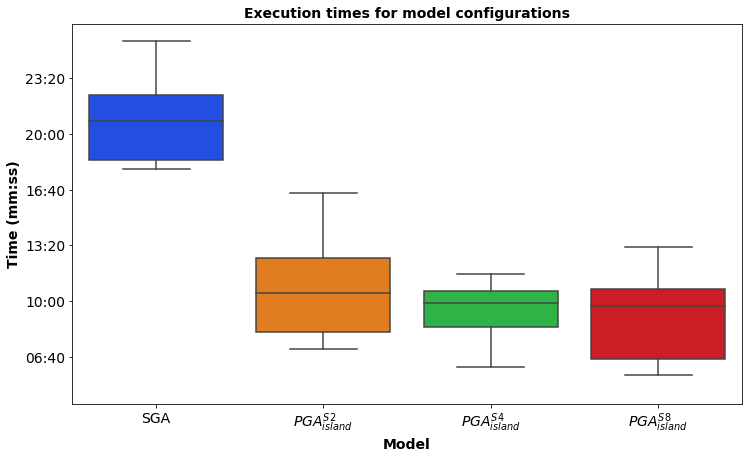

In [42]:
# boxplot
bplt = sns.boxplot(data=config_tt, fliersize=0)
bplt.set_title('Execution times for model configurations', fontweight='bold', fontsize=14)
bplt.set_yticklabels([format_time(x) for x in bplt.get_yticks()], fontsize=14)
plt.xticks(plt.xticks()[0], ['SGA', '$PGA_{island}^{S2}$', '$PGA_{island}^{S4}$', '$PGA_{island}^{S8}$'], fontsize=14)
plt.ylabel('Time (mm:ss)', fontweight='bold', fontsize=14)
plt.xlabel('Model', fontweight='bold', fontsize=14)
plt.show()

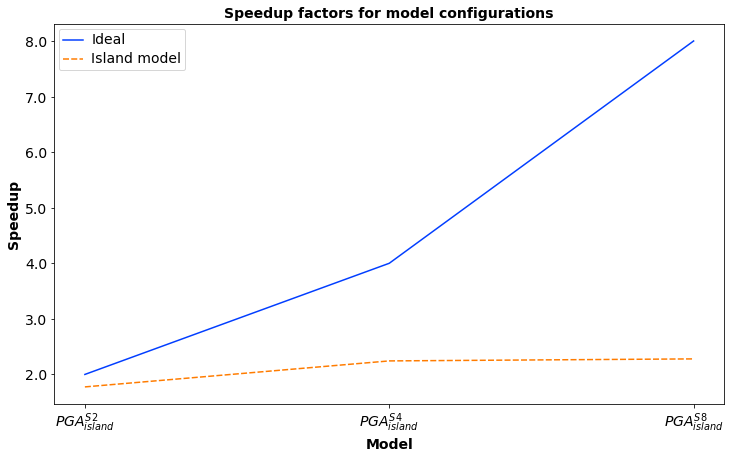

In [58]:
# speedup plot
base_time = summaries[0][0]
speedup_factors = [1 - (x[0] / base_time) for x in summaries]
ideal_factors = [0, 1, 3, 7]

data_preproc = pd.DataFrame({
    'Ideal': [2, 4, 8], 
    'Island model': [(base_time / x[0]) for x in summaries][1:],
})

lplt = sns.lineplot(data=data_preproc)
lplt.set_title('Speedup factors for model configurations', fontweight='bold', fontsize=14)
lplt.set_yticklabels(lplt.get_yticks(), fontsize=14)
plt.xticks(np.arange(3), ['$PGA_{island}^{S2}$', '$PGA_{island}^{S4}$', '$PGA_{island}^{S8}$'], fontsize=14)
plt.ylabel('Speedup', fontweight='bold', fontsize=14)
plt.xlabel('Model', fontweight='bold', fontsize=14)
plt.setp(lplt.get_legend().get_texts(), fontsize='14')
plt.setp(lplt.get_legend().get_title(), fontsize='14')
plt.show()

In [41]:
test_results = [stats.wilcoxon(config_tt_rev[0], config_tt_rev[i+1]) for i in range(3)]
display(HTML(tabulate.tabulate(test_results, tablefmt='html')))

1,0.00691043
0,0.00506203
0,0.00506203


In [55]:
config_gens_avg = np.empty(shape=(4, 10, 300))
config_gens_compare = np.empty(shape=(2, 40))
c = 0

for i in range(4):
    for j in range(10):
        for k in range(300):
            config_gens_avg[i, j, k] = st.mean(config_gens[i, j, k])
        avg_sum = sum(config_gens_avg[i,j,])
        config_gens_compare[0, c] = avg_sum
        config_gens_compare[1, c] = config_tt_rev[i, j] - avg_sum
        c = c + 1

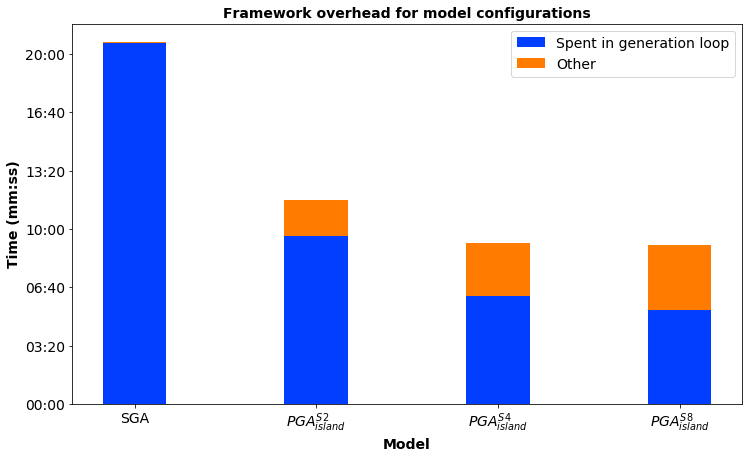

In [57]:
r = np.arange(4)
width = 0.35 

groupped_total = [st.mean(x) for x in np.split(config_gens_compare[0], 4)]
groupped_approx = [st.mean(x) for x in np.split(config_gens_compare[1], 4)]

fig, ax = plt.subplots()
p1 = plt.bar(r, groupped_total, width)
p2 = plt.bar(r, groupped_approx, width,
             bottom=groupped_total)

plt.ylabel('Time (mm:ss)', fontweight='bold', fontsize=14)
plt.xlabel('Model', fontweight='bold', fontsize=14)
plt.title('Framework overhead for model configurations', fontweight='bold', fontsize=14)
ax.set_yticklabels([format_time(x) for x in ax.get_yticks()], fontsize=14)
plt.xticks(r, ['SGA', '$PGA_{island}^{S2}$', '$PGA_{island}^{S4}$', '$PGA_{island}^{S8}$'], fontsize=14)
plt.legend((p1[0], p2[0]), ('Spent in generation loop', 'Other'), fontsize=14)

plt.show()